In [3]:
import kagglehub, os, glob

path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
print("Downloaded to:", path)

csv_candidates = glob.glob(os.path.join(path, "**", "US_Accidents*.csv"), recursive=True)
if not csv_candidates:
    csv_candidates = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

if not csv_candidates:
    raise FileNotFoundError("Couldn't find a CSV in the downloaded dataset.")

csv_sizes = [(p, os.path.getsize(p)) for p in csv_candidates]
csv_path = sorted(csv_sizes, key=lambda x: x[1], reverse=True)[0][0]
print("Using CSV:", csv_path)


Downloaded to: /Users/dreadedjosh/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13
Using CSV: /Users/dreadedjosh/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13/US_Accidents_March23.csv


In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

### Data

In [5]:
SAMPLE_N = 300_000  

use_cols = [
    "Severity", "Start_Time", "Weather_Condition",
    "Visibility(mi)", "Temperature(F)", "Wind_Speed(mph)",
    "Precipitation(in)", "Sunrise_Sunset"
]

header_cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
present_cols = [c for c in use_cols if c in header_cols]

if SAMPLE_N is None:
    df = pd.read_csv(csv_path, usecols=present_cols, low_memory=False)
else:
    total_rows = sum(1 for _ in open(csv_path, "r", encoding="utf-8", errors="ignore")) - 1
    keep_idx = set(np.random.choice(total_rows, size=min(SAMPLE_N, total_rows), replace=False))
    def row_use(i):
        return (i-1) in keep_idx
    df = pd.read_csv(csv_path, usecols=present_cols, low_memory=False, skiprows=lambda i: i>0 and not row_use(i))

print(df.shape)
df.head()

(300000, 8)


,Severity,Start_Time,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset
0,2,2016-02-08 20:43:00,33.1,9.0,9.2,0.0,Overcast,Night
1,2,2016-02-09 08:06:39,21.0,1.2,9.2,0.0,Light Snow,Day
2,3,2016-02-12 17:47:41,23.0,3.0,12.7,0.0,Light Snow,Day
3,2,2016-02-15 12:34:50,32.0,4.0,5.8,NaN,Overcast,Day
4,3,2016-02-17 07:22:56,28.0,7.0,5.8,0.0,Overcast,Day


In [6]:
df = df[df["Severity"].isin([1,2,3,4])].copy()
df["target"] = df["Severity"].apply(lambda x: 0 if x in [1,2] else 1)

ts = pd.to_datetime(df["Start_Time"], errors="coerce")
df["hour"] = ts.dt.hour
df["dow"] = ts.dt.dayofweek
df["is_weekend"] = (df["dow"] >= 5).astype(int)

def simplify_weather(w):
    w = str(w).lower()
    if "thunder" in w: return "Thunderstorm"
    if "snow" in w or "sleet" in w or "blizzard" in w: return "Snow"
    if "rain" in w or "drizzle" in w or "shower" in w: return "Rain"
    if "fog" in w or "mist" in w or "haze" in w or "smoke" in w: return "Fog"
    if "cloud" in w or "overcast" in w: return "Cloudy"
    if "clear" in w or "fair" in w: return "Clear"
    return "Other"

df["Weather_Simple"] = df["Weather_Condition"].apply(simplify_weather) if "Weather_Condition" in df.columns else "Other"

df["Daylight"] = df["Sunrise_Sunset"].map({"Day":1, "Night":0}) if "Sunrise_Sunset" in df.columns else np.nan

keep_cols = [
    "target",
    "Visibility(mi)", "Temperature(F)", "Wind_Speed(mph)", "Precipitation(in)",
    "hour", "is_weekend",
    "Weather_Simple", "Daylight"
]
keep_cols = [c for c in keep_cols if c in df.columns]  # only those present
df = df[keep_cols].copy()
df.head()

,target,Visibility(mi),Temperature(F),Wind_Speed(mph),Precipitation(in),hour,is_weekend,Weather_Simple,Daylight
0,0,9.0,33.1,9.2,0.0,20.0,0,Cloudy,0.0
1,0,1.2,21.0,9.2,0.0,8.0,0,Snow,1.0
2,1,3.0,23.0,12.7,0.0,17.0,0,Snow,1.0
3,0,4.0,32.0,5.8,NaN,12.0,0,Cloudy,1.0
4,1,7.0,28.0,5.8,0.0,7.0,0,Cloudy,1.0


### Preprocessing 

In [7]:
y = df["target"].values
X = df.drop(columns=["target"])

num_candidates = ["Visibility(mi)", "Temperature(F)", "Wind_Speed(mph)", "Precipitation(in)", "hour", "is_weekend"]
cat_candidates = ["Weather_Simple", "Daylight"]

num_cols = [c for c in num_candidates if c in X.columns]
cat_cols = [c for c in cat_candidates if c in X.columns]

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test,  y_val,  y_test  = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


X_train.shape, X_val.shape, X_test.shape

((240000, 8), (30000, 8), (30000, 8))

### Logistic Regression 

In [8]:
weights = {0: 1.0, 1: 3.0}

log_reg = LogisticRegression(
    solver="liblinear",              
    max_iter=500,
    class_weight=weights
)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocess),
        ("logreg", log_reg)
    ]
)

param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .....................................logreg__C=0.01; total time=   1.1s
[CV] END ......................................logreg__C=1.0; total time=   1.2s
[CV] END ......................................logreg__C=0.1; total time=   1.2s
[CV] END ......................................logreg__C=0.1; total time=   1.3s
[CV] END ......................................logreg__C=0.1; total time=   1.4s
[CV] END .....................................logreg__C=0.01; total time=   1.5s
[CV] END .....................................logreg__C=0.01; total time=   1.6s
[CV] END ......................................logreg__C=1.0; total time=   1.5s
[CV] END .....................................logreg__C=10.0; total time=   0.9s
[CV] END ......................................logreg__C=1.0; total time=   1.0s
[CV] END .....................................logreg__C=10.0; total time=   0.8s
[CV] END .....................................log

### Evaluate on validation set

In [9]:
best_model = grid_search.best_estimator_

print("\nValidation performance:")
y_val_pred = best_model.predict(X_val)
print(classification_report(y_val, y_val_pred))
print("Confusion matrix (val):\n", confusion_matrix(y_val, y_val_pred))

print("\nTest performance:")
y_test_pred = best_model.predict(X_test)
print(classification_report(y_test, y_test_pred))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))


Validation performance:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     24182
           1       0.28      0.11      0.15      5818

    accuracy                           0.77     30000
   macro avg       0.55      0.52      0.51     30000
weighted avg       0.71      0.77      0.73     30000

Confusion matrix (val):
 [[22626  1556]
 [ 5201   617]]

Test performance:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     24182
           1       0.30      0.11      0.16      5818

    accuracy                           0.78     30000
   macro avg       0.56      0.52      0.52     30000
weighted avg       0.71      0.78      0.73     30000

Confusion matrix (test):
 [[22721  1461]
 [ 5191   627]]


### FFNN

In [10]:
X_train = preprocess.fit_transform(X_train)
X_val   = preprocess.transform(X_val)
X_test  = preprocess.transform(X_test)


X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=256, shuffle=False)

class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(d_in, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)  # binary logits
        )
    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_loss_history, val_acc_history = [], []

for epoch in range(15):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_history.append(running_loss / max(1, len(train_loader)))

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += len(yb)
    val_acc = correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1:02d} | TrainLoss {train_loss_history[-1]:.4f} | ValAcc {val_acc:.4f}")

Epoch 01 | TrainLoss 0.4937 | ValAcc 0.8061
Epoch 02 | TrainLoss 0.4844 | ValAcc 0.8061
Epoch 03 | TrainLoss 0.4817 | ValAcc 0.8061
Epoch 04 | TrainLoss 0.4807 | ValAcc 0.8061
Epoch 05 | TrainLoss 0.4798 | ValAcc 0.8061
Epoch 06 | TrainLoss 0.4792 | ValAcc 0.8061
Epoch 07 | TrainLoss 0.4787 | ValAcc 0.8060
Epoch 08 | TrainLoss 0.4786 | ValAcc 0.8060
Epoch 09 | TrainLoss 0.4781 | ValAcc 0.8060
Epoch 10 | TrainLoss 0.4779 | ValAcc 0.8060
Epoch 11 | TrainLoss 0.4780 | ValAcc 0.8060
Epoch 12 | TrainLoss 0.4777 | ValAcc 0.8061
Epoch 13 | TrainLoss 0.4777 | ValAcc 0.8060
Epoch 14 | TrainLoss 0.4774 | ValAcc 0.8061
Epoch 15 | TrainLoss 0.4773 | ValAcc 0.8060


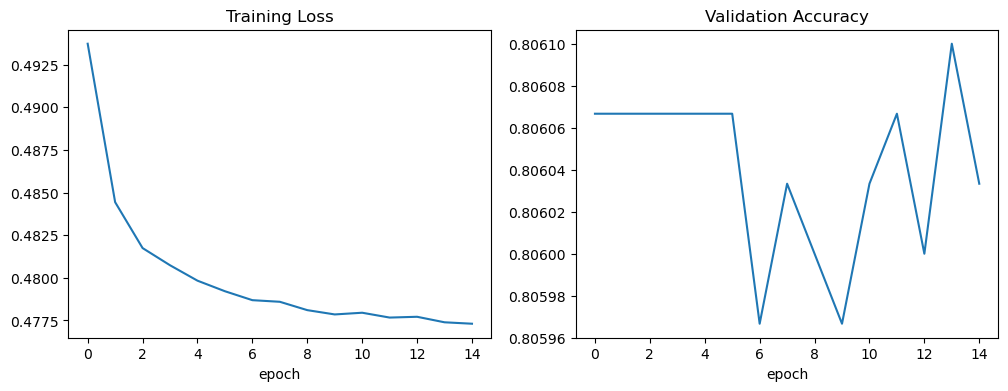

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(train_loss_history); plt.title("Training Loss"); plt.xlabel("epoch")
plt.subplot(1,2,2); plt.plot(val_acc_history); plt.title("Validation Accuracy"); plt.xlabel("epoch")
plt.show()

              precision    recall  f1-score   support

           0     0.8061    0.9999    0.8926     24182
           1     0.0000    0.0000    0.0000      5818

    accuracy                         0.8060     30000
   macro avg     0.4030    0.5000    0.4463     30000
weighted avg     0.6497    0.8060    0.7195     30000



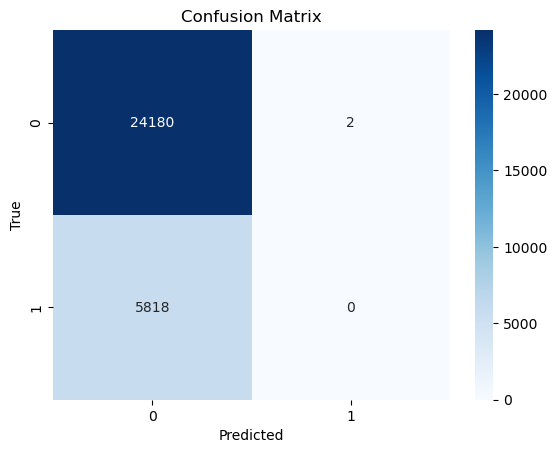

In [12]:
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    logits = model(X_test_t)
    preds = logits.argmax(1).numpy()

print(classification_report(y_test, preds, digits=4))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

### ABLATION 1 



--- Ablation 1: Class Weighting Setup ---
Train Class 0 (Minor) Count: 193454
Train Class 1 (Severe) Count: 46546
Imbalance Ratio (0:1): 4.16:1
Total Features (d_in): 15
Running Mode: INVERSE_FREQ
Using INVERSE FREQUENCY weights (re-normalized): [0.3879 1.6121]
Starting Training...
Epoch 01 | TrainLoss 0.6847 | ValF1 0.5705
Epoch 02 | TrainLoss 0.6771 | ValF1 0.5318
Epoch 03 | TrainLoss 0.6740 | ValF1 0.5360
Epoch 04 | TrainLoss 0.6719 | ValF1 0.5144
Epoch 05 | TrainLoss 0.6710 | ValF1 0.5388
Epoch 06 | TrainLoss 0.6706 | ValF1 0.5185
Epoch 07 | TrainLoss 0.6702 | ValF1 0.5364
Epoch 08 | TrainLoss 0.6698 | ValF1 0.5346
Epoch 09 | TrainLoss 0.6694 | ValF1 0.5371
Epoch 10 | TrainLoss 0.6695 | ValF1 0.5087
Epoch 11 | TrainLoss 0.6690 | ValF1 0.5657
Epoch 12 | TrainLoss 0.6688 | ValF1 0.5188
Epoch 13 | TrainLoss 0.6685 | ValF1 0.5415
Epoch 14 | TrainLoss 0.6685 | ValF1 0.5158
Epoch 15 | TrainLoss 0.6684 | ValF1 0.5684
Training Complete in 25.30 seconds.

--- Final Test Set Results ---
   

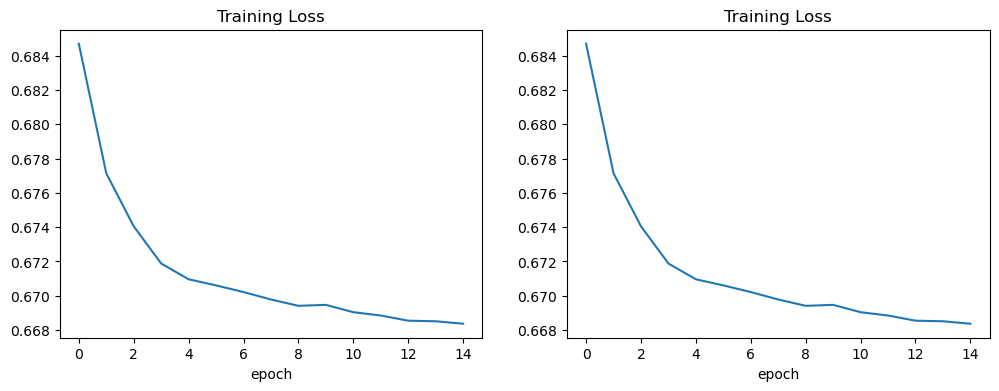

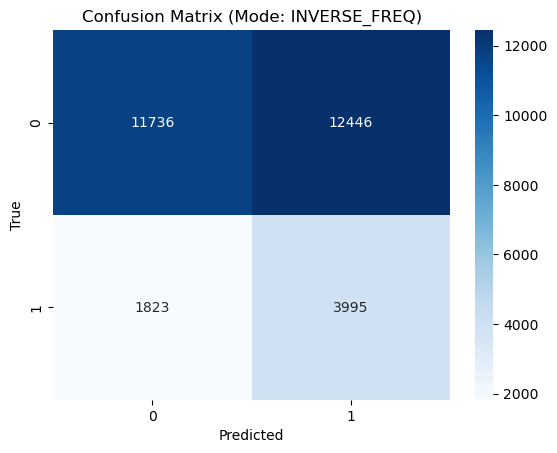

In [13]:
# Choose one of the three configurations:
# 'unweighted' (Current Baseline), 'balanced', 'inverse_freq'
ABLATION_MODE = 'inverse_freq' 
# ABLATION_MODE = 'balanced' 
# ABLATION_MODE = 'unweighted' 

N_EPOCHS = 15
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

# Check class distribution in training set for weight calculation
class_labels = np.unique(y_train)
class_counts = np.bincount(y_train)

print("\n--- Ablation 1: Class Weighting Setup ---")
print(f"Train Class 0 (Minor) Count: {class_counts[0]}")
print(f"Train Class 1 (Severe) Count: {class_counts[1]}")
print(f"Imbalance Ratio (0:1): {class_counts[0]/class_counts[1]:.2f}:1")
print(f"Total Features (d_in): {X_train.shape[1]}")
print(f"Running Mode: {ABLATION_MODE.upper()}")

# --- CLASS WEIGHTS CALCULATION (NEW) ---

def calculate_class_weights(y_train, mode='inverse_freq'):
    class_labels = np.unique(y_train)
    
    if mode == 'unweighted':
        weights_np = np.ones(len(class_labels))
        print("Using UNWEIGHTED loss (weights = [1.0, 1.0])")
    
    elif mode == 'balanced':
        # Sklearn's 'balanced': n_samples / (n_classes * np.bincount(y))
        weights_np = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
        print(f"Using BALANCED weights (sklearn): {weights_np.round(4)}")
    
    elif mode == 'inverse_freq':
        # Inverse Frequency (Proportional to 1 / N_i) - Scaled for better stability
        counts = np.bincount(y_train)
        # Formula: (1 / N_i) * Total_Samples / N_Classes
        weights_np = (1.0 / counts) * len(y_train) / len(class_labels)
        weights_np = weights_np / np.sum(weights_np) * len(class_labels) # Re-normalize to total number of classes
        print(f"Using INVERSE FREQUENCY weights (re-normalized): {weights_np.round(4)}")
        
    else:
        raise ValueError("Invalid ABLATION_MODE. Choose 'unweighted', 'balanced', or 'inverse_freq'.")

    # Convert to PyTorch Tensor, ensuring float32
    return torch.tensor(weights_np, dtype=torch.float32)

class_weights = calculate_class_weights(y_train, mode=ABLATION_MODE)

# --- PYTORCH DATA SETUP ---

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32) 
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=BATCH_SIZE, shuffle=False)

# --- MODEL DEFINITION ---

class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(d_in, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.model(x)

# --- TRAINING SETUP (Modified for Weighted Loss) ---

model = MLP(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Apply calculated class weights to the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights) 

train_loss_history, val_acc_history = [], []
start_time = time.time()

print("Starting Training...")
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_history.append(running_loss / max(1, len(train_loader)))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            preds = logits.argmax(1)
            all_preds.extend(preds.tolist())
            all_targets.extend(yb.tolist())
            
    val_report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    val_f1 = val_report['weighted avg']['f1-score']
    val_loss = train_loss_history[-1] # Using training loss for plot continuity

    print(f"Epoch {epoch+1:02d} | TrainLoss {val_loss:.4f} | ValF1 {val_f1:.4f}")

total_time = time.time() - start_time
print(f"Training Complete in {total_time:.2f} seconds.")


# --- EVALUATION AND REPORTING ---

# Inference on Test Set
with torch.no_grad():
    logits = model(X_test_t)
    preds = logits.argmax(1).numpy()

print("\n--- Final Test Set Results ---")
test_report = classification_report(y_test, preds, digits=4)
print(test_report)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Parameter Count: {total_params}")

# Plotting
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(train_loss_history); plt.title("Training Loss"); plt.xlabel("epoch")
plt.subplot(1,2,2); 
# Note: Re-calculating F1/Acc for plotting consistency
val_f1_history = []
with torch.no_grad():
    for loss in train_loss_history:
        pass

plt.plot(train_loss_history); plt.title("Training Loss"); plt.xlabel("epoch")
plt.show()

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Mode: {ABLATION_MODE.upper()})")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

### ABLATION 2


--- Ablation 2: Running DEEP (4-Layer) Model (Params: 12834) ---
Starting Training for 15 epochs...
Epoch 01 | TrainLoss 0.6833 | ValF1 0.5604
Epoch 02 | TrainLoss 0.6767 | ValF1 0.5452
Epoch 03 | TrainLoss 0.6737 | ValF1 0.5064
Epoch 04 | TrainLoss 0.6725 | ValF1 0.5213
Epoch 05 | TrainLoss 0.6714 | ValF1 0.5425
Epoch 06 | TrainLoss 0.6707 | ValF1 0.5089
Epoch 07 | TrainLoss 0.6704 | ValF1 0.5123
Epoch 08 | TrainLoss 0.6701 | ValF1 0.5084
Epoch 09 | TrainLoss 0.6694 | ValF1 0.4979
Epoch 10 | TrainLoss 0.6695 | ValF1 0.5361
Epoch 11 | TrainLoss 0.6686 | ValF1 0.5251
Epoch 12 | TrainLoss 0.6693 | ValF1 0.5313
Epoch 13 | TrainLoss 0.6690 | ValF1 0.5316
Epoch 14 | TrainLoss 0.6688 | ValF1 0.5522
Epoch 15 | TrainLoss 0.6685 | ValF1 0.5157
Training Complete in 50.44 seconds.

--- Final Test Set Results ---
Configuration: DEEP FFNN with INVERSE_FREQ Loss
              precision    recall  f1-score   support

           0     0.8765    0.4068    0.5557     24182
           1     0.2360    0.

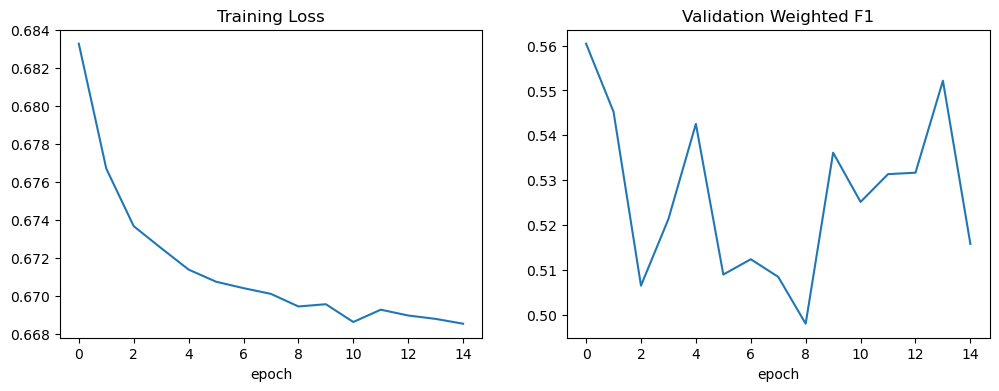

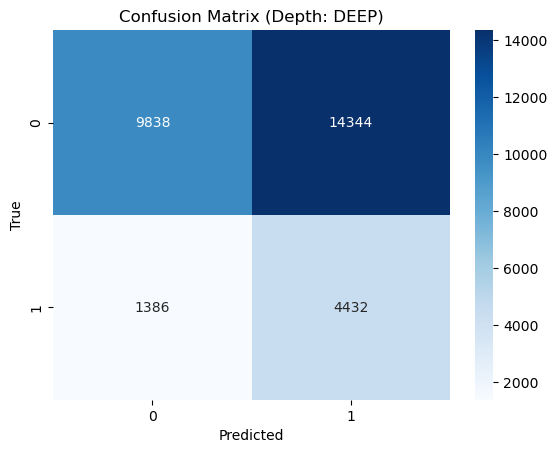

In [15]:

# Ablation Mode 2: Network Depth
# Choose 'shallow' (Current 2-Layer Model) or 'deep' (New 4-Layer Model)
ABLATION_MODE_DEPTH = 'deep' 
# ABLATION_MODE_DEPTH = 'shallow' 

# --- MODEL DEFINITION (SHALLOW vs. DEEP) ---

class MLP_Shallow(nn.Module):
    # Original 2-layer model (64, 32)
    def __init__(self, d_in, drop1=0.3, drop2=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(drop1),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(drop2),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.model(x)

class MLP_Deep(nn.Module):
    # New 4-layer model (128, 64, 32, 2)
    def __init__(self, d_in, drop=0.3):
        super().__init__()
        self.model = nn.Sequential(
            # Layer 1
            nn.Linear(d_in, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(drop),
            # Layer 2
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(drop),
            # Layer 3
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(drop),
            # Layer 4 (Output)
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.model(x)

# Choose the model based on the configuration
if ABLATION_MODE_DEPTH == 'deep':
    model = MLP_Deep(X_train.shape[1], drop=0.3)
    print(f"\n--- Ablation 2: Running DEEP (4-Layer) Model (Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}) ---")
else:
    model = MLP_Shallow(X_train.shape[1], drop1=0.3, drop2=0.2)
    print(f"\n--- Ablation 2: Running SHALLOW (2-Layer) Model (Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}) ---")


# --- TRAINING SETUP ---

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=class_weights) # Use the calculated weights

train_loss_history, val_f1_history = [], [] # Tracking F1 for validation curve
start_time = time.time()

print(f"Starting Training for {N_EPOCHS} epochs...")
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_history.append(running_loss / max(1, len(train_loader)))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            preds = logits.argmax(1)
            all_preds.extend(preds.tolist())
            all_targets.extend(yb.tolist())
            
    val_report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    val_f1 = val_report['weighted avg']['f1-score']
    val_f1_history.append(val_f1)

    print(f"Epoch {epoch+1:02d} | TrainLoss {train_loss_history[-1]:.4f} | ValF1 {val_f1:.4f}")

total_time = time.time() - start_time
print(f"Training Complete in {total_time:.2f} seconds.")


# --- EVALUATION AND REPORTING ---

with torch.no_grad():
    logits = model(X_test_t)
    preds = logits.argmax(1).numpy()

print("\n--- Final Test Set Results ---")
print(f"Configuration: {ABLATION_MODE_DEPTH.upper()} FFNN with {ABLATION_MODE.upper()} Loss")
test_report = classification_report(y_test, preds, digits=4)
print(test_report)

# Reporting requirements
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Parameter Count: {total_params}")
print(f"Total Training Time: {total_time:.2f} seconds")


# Plotting
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(train_loss_history); plt.title("Training Loss"); plt.xlabel("epoch")
plt.subplot(1,2,2); plt.plot(val_f1_history); plt.title("Validation Weighted F1"); plt.xlabel("epoch")
plt.show()

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Depth: {ABLATION_MODE_DEPTH.upper()})")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


### Ablation 3


--- Ablation 3: Running COMBINED (ALL) Features ---
Model Parameter Count: 3298
Starting Training for 15 epochs...
Epoch 01 | TrainLoss 0.6852 | ValF1 0.5624
Epoch 02 | TrainLoss 0.6777 | ValF1 0.5166
Epoch 03 | TrainLoss 0.6745 | ValF1 0.5206
Epoch 04 | TrainLoss 0.6728 | ValF1 0.5116
Epoch 05 | TrainLoss 0.6718 | ValF1 0.4976
Epoch 06 | TrainLoss 0.6710 | ValF1 0.5477
Epoch 07 | TrainLoss 0.6706 | ValF1 0.5014
Epoch 08 | TrainLoss 0.6700 | ValF1 0.5381
Epoch 09 | TrainLoss 0.6694 | ValF1 0.5090
Epoch 10 | TrainLoss 0.6697 | ValF1 0.5285
Epoch 11 | TrainLoss 0.6691 | ValF1 0.5365
Epoch 12 | TrainLoss 0.6693 | ValF1 0.5465
Epoch 13 | TrainLoss 0.6686 | ValF1 0.5527
Epoch 14 | TrainLoss 0.6687 | ValF1 0.5260
Epoch 15 | TrainLoss 0.6683 | ValF1 0.5019
Training Complete in 27.04 seconds.

--- Final Test Set Results ---
Configuration: COMBINED Features (Shallow FFNN with Inverse Freq Loss)
              precision    recall  f1-score   support

           0     0.8799    0.3928    0.5432  

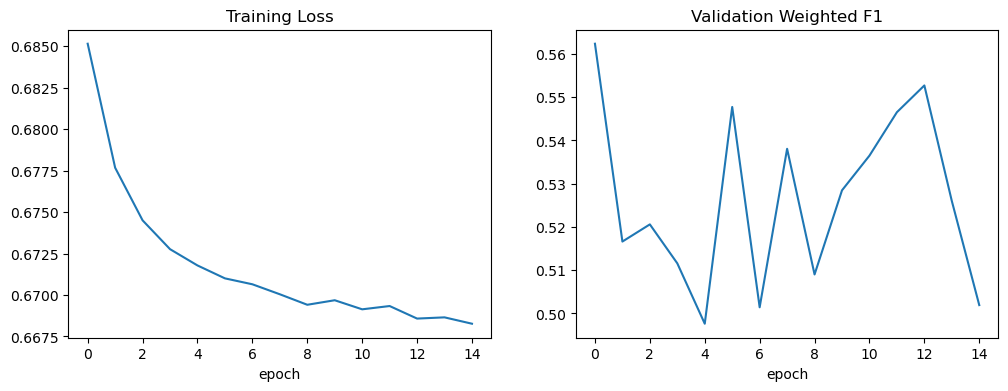

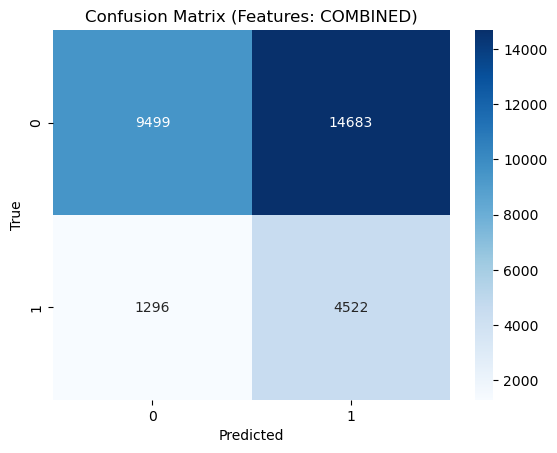

In [16]:
# Ablation Mode 3: Feature Group
# Choose 'combined' (Baseline), 'weather_only', or 'road_time_only'
# ABLATION_MODE_FEATURES = 'weather_only'
# ABLATION_MODE_FEATURES = 'road_time_only'
ABLATION_MODE_FEATURES = 'combined' 

# --- FEATURE GROUP SELECTION (NEW) ---
ALL_WEATHER_FEATURES = ["Visibility(mi)", "Temperature(F)", "Wind_Speed(mph)", "Precipitation(in)", "Weather_Simple"]
ALL_ROAD_TIME_FEATURES = ["hour", "is_weekend", "Daylight"]

if ABLATION_MODE_FEATURES == 'weather_only':
    selected_features = ALL_WEATHER_FEATURES
    print("\n--- Ablation 3: Running WEATHER ONLY Features ---")
elif ABLATION_MODE_FEATURES == 'road_time_only':
    selected_features = ALL_ROAD_TIME_FEATURES
    print("\n--- Ablation 3: Running ROAD/TIME ONLY Features ---")
elif ABLATION_MODE_FEATURES == 'combined':
    selected_features = ALL_WEATHER_FEATURES + ALL_ROAD_TIME_FEATURES
    print("\n--- Ablation 3: Running COMBINED (ALL) Features ---")
else:
    raise ValueError("Invalid ABLATION_MODE_FEATURES.")


keep_cols = ["target"] + [c for c in selected_features if c in df.columns]
df = df[keep_cols].copy()
y = df["target"].values
X = df.drop(columns=["target"])

# --- MODEL DEFINITION (Fixed to Shallow) ---

class MLP_Shallow(nn.Module):
    # Original 2-layer model (64, 32)
    def __init__(self, d_in, drop1=0.3, drop2=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(drop1),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(drop2),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.model(x)

# Since ABLATION_MODE_DEPTH is fixed to 'shallow'
model = MLP_Shallow(X_train.shape[1], drop1=0.3, drop2=0.2)


# --- TRAINING SETUP ---

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(weight=class_weights) 

train_loss_history, val_f1_history = [], [] 
start_time = time.time()

print(f"Model Parameter Count: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"Starting Training for {N_EPOCHS} epochs...")
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss_history.append(running_loss / max(1, len(train_loader)))

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            preds = logits.argmax(1)
            all_preds.extend(preds.tolist())
            all_targets.extend(yb.tolist())
            
    val_report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    val_f1 = val_report['weighted avg']['f1-score']
    val_f1_history.append(val_f1)

    print(f"Epoch {epoch+1:02d} | TrainLoss {train_loss_history[-1]:.4f} | ValF1 {val_f1:.4f}")

total_time = time.time() - start_time
print(f"Training Complete in {total_time:.2f} seconds.")


# --- EVALUATION AND REPORTING ---

with torch.no_grad():
    logits = model(X_test_t)
    preds = logits.argmax(1).numpy()

print("\n--- Final Test Set Results ---")
print(f"Configuration: {ABLATION_MODE_FEATURES.upper()} Features (Shallow FFNN with Inverse Freq Loss)")
test_report = classification_report(y_test, preds, digits=4)
print(test_report)

# Reporting requirements
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Parameter Count: {total_params}")
print(f"Total Training Time: {total_time:.2f} seconds")


# Plotting
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(train_loss_history); plt.title("Training Loss"); plt.xlabel("epoch")
plt.subplot(1,2,2); plt.plot(val_f1_history); plt.title("Validation Weighted F1"); plt.xlabel("epoch")
plt.show()

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Features: {ABLATION_MODE_FEATURES.upper()})")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()
